# Dall'analisi descrittiva alla modellazione cognitiva {#sec-cognitive-modeling}

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [8]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from cmdstanpy import CmdStanModel

# Configuration
seed = sum(map(ord, "cog_mod_comp"))
rng = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

In [9]:
seed: int = sum(map(ord, "subj_prop"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

## Introduzione

Nell'analisi dei dati psicologici, l'approccio tradizionale si basa spesso su confronti descrittivi, come la differenza tra le medie di due condizioni sperimentali. Sebbene questo approccio possa fornire informazioni utili, è limitato nella sua capacità di rivelare la complessità dei processi psicologici sottostanti. Un'analisi che si fermi a questo livello rischia di non cogliere la ricchezza dei meccanismi psicologici che realmente generano i dati osservati. Come sottolineato da @McElreath_rethinking, un vero avanzamento nella comprensione dei fenomeni richiede l'adozione di modelli che siano esplicitamente formulati in termini di processi generativi sottostanti. 

Un modello generativo non si limita a descrivere i dati; piuttosto, esso riflette un'ipotesi teorica su come i dati vengano effettivamente prodotti. Questo tipo di modellizzazione consente di testare ipotesi teoriche complesse e di confrontare l'adeguatezza di diversi modelli esplicativi. In questo modo, la ricerca non solo quantifica differenze osservate, ma esplora le cause e i processi che le determinano, permettendo un'interpretazione più profonda e teoricamente informata dei risultati.

In questo tutorial, vengono confrontati due approcci modellistici diversi: un modello semplice e descrittivo, e un modello processuale più complesso, che incorpora una teoria esplicita del processo cognitivo sottostante. Il primo modello rappresenta un approccio tradizionale, che si limita a distinguere tra due condizioni senza tener conto del meccanismo generativo che potrebbe differenziarle. Il secondo modello, invece, è costruito su un'ipotesi teorica che descrive come il processo cognitivo operi in ciascuna delle due condizioni. Attraverso questo confronto, mostreremo come un modello che incorpora esplicitamente il processo cognitivo possa fornire un'interpretazione più ricca e accurata dei dati, rispetto a un modello che si limita a descrivere differenze superficiali.

L'obiettivo di questo capitolo è quindi dimostrare l'importanza di adottare modelli generativi nella ricerca psicologica, evidenziando come essi possano superare le limitazioni degli approcci descrittivi tradizionali e fornire intuizioni più profonde sul funzionamento dei fenomeni psicologici.

## Modello "Process"

Il modello "process" ipotizza un meccanismo cognitivo in cui l'accuratezza delle risposte di un soggetto in un compito può variare in base a due condizioni sperimentali: una condizione di "alto apprendimento" e una condizione di "basso apprendimento". L'idea di base è che nella condizione di alto apprendimento, il soggetto non solo apprende dalle risposte precedenti, migliorando gradualmente la sua accuratezza, ma subisce anche un decadimento di tale apprendimento nel tempo. Nella condizione di basso apprendimento, invece, il soggetto non migliora nel tempo, mantenendo un livello costante di accuratezza.

Questa dinamica riflette un processo di apprendimento che è modulato da due forze opposte: un *tasso di apprendimento* che permette al soggetto di migliorare la sua performance in base agli errori commessi, e un *tasso di decadimento* che riduce gradualmente l'effetto dell'apprendimento nel tempo. Questo modello è più complesso rispetto a un modello descrittivo semplice perché tenta di catturare il processo dinamico di come l'accuratezza evolve durante il compito, piuttosto che limitarsi a descrivere una differenza fissa tra due condizioni.

**Implementazione del Modello**

1. **Dati di Input**
   - **N:** Il numero totale di prove (trials) a cui il soggetto è sottoposto.
   - **y:** Un array binario (0 o 1) che rappresenta l'accuratezza di ciascuna risposta. Un valore di `1` indica una risposta corretta, mentre un valore di `0` indica una risposta errata.
   - **condition:** Un array binario che indica la condizione sperimentale per ciascuna prova: `1` se il soggetto è nella condizione di "alto apprendimento" e `0` se è nella condizione di "basso apprendimento".

2. **Parametri del Modello**
   - **theta_initial:** Rappresenta l'accuratezza iniziale del soggetto, prima che qualsiasi apprendimento o decadimento abbia avuto luogo.
   - **learning_rate:** Rappresenta il tasso di apprendimento, ovvero quanto rapidamente il soggetto migliora in risposta agli errori precedenti.
   - **decay_rate:** Rappresenta il tasso di decadimento, ovvero quanto velocemente l'effetto dell'apprendimento diminuisce nel tempo.

3. **Distribuzioni A Priori**
   - I parametri **theta_initial**, **learning_rate** e **decay_rate** sono tutti modellati come variabili aleatorie con distribuzioni beta. La distribuzione beta è spesso utilizzata per modellare probabilità, poiché è limitata tra 0 e 1 e può assumere varie forme in base ai parametri scelti.

4. **Implementazione del Processo Cognitivo**
   - Il modello si sviluppa in modo iterativo per ciascuna prova, a partire dalla seconda (la prima prova è gestita separatamente perché non ha una risposta precedente da cui apprendere).
   - Per ogni prova successiva:
     - Viene calcolata la probabilità di risposta corretta (`p`) in base alla condizione corrente.
     - Se la condizione è di "alto apprendimento" (`condition[n] == 1`), la probabilità di risposta corretta viene aggiornata in base a una combinazione di decadimento e apprendimento:
       - La parte **(1 - decay_rate) * theta_initial** riduce l'influenza dell'accuratezza iniziale, simulando il decadimento.
       - La parte **learning_rate * (1 - y[n - 1])** aumenta la probabilità di una risposta corretta se la prova precedente è stata errata, simulando l'apprendimento dagli errori.
     - La funzione **fmin** e **fmax** sono utilizzate per assicurarsi che la probabilità `p` rimanga all'interno dell'intervallo [0, 1].
   - Se la condizione è di "basso apprendimento" (`condition[n] == 0`), la probabilità di risposta corretta rimane invariata a **theta_initial**.

5. **Generazione dei Dati Simulati**
   - Nella sezione `generated quantities`, il modello genera dati simulati (`y_rep`) e calcola la log-verosimiglianza (`log_lik`) per ciascuna prova. Questo è utile per confrontare la bontà di adattamento del modello rispetto ai dati osservati.
   - Per ogni prova, viene calcolata la probabilità di una risposta corretta e quindi viene generato un valore simulato usando la funzione **bernoulli_rng**. Il valore di log-verosimiglianza viene calcolato utilizzando **bernoulli_lpmf**.

Il modello "process" cerca di rappresentare un meccanismo cognitivo complesso, in cui l'accuratezza delle risposte varia dinamicamente in base a un processo di apprendimento e decadimento. Questo approccio permette di testare ipotesi più articolate sui dati, andando oltre una semplice descrizione delle differenze tra condizioni e cercando di catturare la struttura cognitiva che guida il comportamento osservato.

In [10]:
stan_file = os.path.join(project_directory, "stan", "cognitive_process_model.stan")
process_model = CmdStanModel(stan_file=stan_file)
print(process_model.code())

data {
  int<lower=0> N; // number of trials
  array[N] int<lower=0, upper=1> y; // accuracy (0 or 1)
  array[N] int<lower=0, upper=1> condition; // 1 if high learning, 0 if low learning
}
parameters {
  real<lower=0, upper=1> theta_initial; // initial accuracy
  real<lower=0, upper=1> learning_rate; // learning rate
  real<lower=0, upper=1> decay_rate; // decay rate
}
model {
  // Priors
  theta_initial ~ beta(2, 2);
  learning_rate ~ beta(2, 2);
  decay_rate ~ beta(2, 2);
  
  for (n in 2 : N) {
    real p = condition[n]
             * fmin(fmax((1 - decay_rate) * theta_initial
                         + learning_rate * (1 - y[n - 1]), 0),
                    1)
             + (1 - condition[n]) * theta_initial;
    y[n] ~ bernoulli(p);
  }
}
generated quantities {
  array[N] int<lower=0, upper=1> y_rep;
  array[N] real log_lik;
  
  y_rep[1] = bernoulli_rng(theta_initial); // First trial based on initial theta
  log_lik[1] = bernoulli_lpmf(y[1] | theta_initial);
  
  for (n in 2 : N

## Modello "Simpler"

Il modello "simpler" è un approccio più basilare per modellare i dati, in cui si assume che l'accuratezza delle risposte in ciascuna prova dipenda esclusivamente dalla condizione sperimentale (alta o bassa) in cui si trova il soggetto. A differenza del modello "process", che tiene conto di come l'accuratezza possa evolvere dinamicamente in funzione dell'apprendimento e del decadimento, il modello "simpler" presuppone che l'accuratezza sia costante all'interno di ciascuna condizione e non cambi nel tempo.

In altre parole, il modello "simpler" cerca di cogliere solo la differenza di accuratezza tra due condizioni, senza considerare l'evoluzione della performance nel corso delle prove. Questo approccio è più limitato e descrittivo, e non tenta di spiegare il processo sottostante che potrebbe dare origine ai dati osservati.

**Implementazione del Modello**

1. **Dati di Input**
   - **N:** Il numero totale di prove (trials) a cui il soggetto è sottoposto.
   - **y:** Un array binario (0 o 1) che rappresenta l'accuratezza di ciascuna risposta. Un valore di `1` indica una risposta corretta, mentre un valore di `0` indica una risposta errata.
   - **condition:** Un array binario che indica la condizione sperimentale per ciascuna prova: `1` se il soggetto è nella condizione di "alto apprendimento" e `0` se è nella condizione di "basso apprendimento".

2. **Parametri del Modello**
   - **theta_high:** Rappresenta l'accuratezza nelle prove in cui il soggetto è nella condizione di "alto apprendimento".
   - **theta_low:** Rappresenta l'accuratezza nelle prove in cui il soggetto è nella condizione di "basso apprendimento".

3. **Distribuzioni A Priori**
   - I parametri **theta_high** e **theta_low** sono modellati come variabili aleatorie con distribuzioni beta. Come nel modello "process", la distribuzione beta è scelta perché è limitata tra 0 e 1, rendendola adatta per modellare probabilità.

4. **Implementazione del Modello**
   - Il modello assume che per ogni prova ci sia una probabilità `p` di ottenere una risposta corretta, che dipende dalla condizione in cui si trova il soggetto.
   - Se il soggetto è nella condizione di "alto apprendimento" (`condition[n] == 1`), la probabilità `p` è semplicemente uguale a **theta_high**.
   - Se il soggetto è nella condizione di "basso apprendimento" (`condition[n] == 0`), la probabilità `p` è uguale a **theta_low**.
   - In pratica, per ogni prova, il modello stima la probabilità di risposta corretta in base alla condizione sperimentale senza considerare alcuna evoluzione dinamica della performance.

5. **Generazione dei Dati Simulati**
   - Nella sezione `generated quantities`, il modello genera dati simulati (`y_rep`) e calcola la log-verosimiglianza (`log_lik`) per ciascuna prova.
   - Per ogni prova, viene calcolata la probabilità di una risposta corretta e quindi viene generato un valore simulato usando la funzione **bernoulli_rng**. Il valore di log-verosimiglianza viene calcolato utilizzando **bernoulli_lpmf**.

Il modello "process" e il modello "simpler" differiscono in modo sostanziale nel modo in cui cercano di spiegare i dati:

1. **Dinamica dell'apprendimento vs. Accuratezza fissa:**
   - **Process Model:** Tiene conto che l'accuratezza possa variare nel tempo in risposta agli errori e al decadimento, catturando la complessità del processo di apprendimento influenzato dalla condizione sperimentale.
   - **Simpler Model:** Assume un'accuratezza costante all'interno di ciascuna condizione, senza considerare variazioni dinamiche dovute all'apprendimento o al decadimento.

2. **Complessità del Meccanismo Cognitivo:**
   - **Process Model:** Rappresenta in modo dettagliato il meccanismo cognitivo che guida la performance, considerando l'evoluzione della performance basata sulle esperienze precedenti.
   - **Simpler Model:** Fornisce una descrizione statica e limitata alle differenze medie tra condizioni, senza approfondire il processo sottostante.

3. **Capacità Predittiva:**
   - **Process Model:** Dovrebbe predire meglio i dati quando l'apprendimento o il decadimento sono rilevanti, grazie alla sua considerazione delle dinamiche temporali.
   - **Simpler Model:** Potrebbe non cogliere adeguatamente la struttura dei dati in presenza di tali dinamiche, risultando meno preciso nelle predizioni.

In sintesi, il modello "simpler" non riesce a catturare i cambiamenti dinamici nell'accuratezza legati al compito, offrendo solo una descrizione media delle differenze tra condizioni. Pertanto, quando i dati seguono un processo di apprendimento o decadimento, il modello "simpler" tende a essere meno efficace rispetto al modello "process".

In [11]:
stan_simpler_file = os.path.join(
    project_directory, "stan", "cognitive_simpler_model.stan"
)
simpler_model = CmdStanModel(stan_file=stan_simpler_file)
print(simpler_model.code())

data {
  int<lower=0> N; // number of trials
  array[N] int<lower=0, upper=1> y; // accuracy (0 or 1)
  array[N] int<lower=0, upper=1> condition; // 1 if high learning, 0 if low learning
}
parameters {
  real<lower=0, upper=1> theta_high; // accuracy in condition 1
  real<lower=0, upper=1> theta_low; // accuracy in condition 0
}
model {
  // Priors
  theta_high ~ beta(2, 2);
  theta_low ~ beta(2, 2);
  
  for (n in 1 : N) {
    real p = condition[n] * theta_high + (1 - condition[n]) * theta_low;
    y[n] ~ bernoulli(p);
  }
}
generated quantities {
  array[N] int<lower=0, upper=1> y_rep;
  array[N] real log_lik;
  
  for (n in 1 : N) {
    real p = condition[n] * theta_high + (1 - condition[n]) * theta_low;
    y_rep[n] = bernoulli_rng(p);
    log_lik[n] = bernoulli_lpmf(y[n] | p);
  }
}



## Simulazione dei Dati

I dati sono stati simulati in base al meccanismo generativo ipotizzato dal modello "process". Questo modello assume che l'accuratezza delle risposte non sia costante nel tempo, ma che evolva dinamicamente in funzione dell'apprendimento e del decadimento. In altre parole, il modello "process" riflette un processo cognitivo in cui i soggetti possono migliorare la loro performance attraverso l'apprendimento, o al contrario, possono mostrare un calo di prestazioni a causa della fatica o della perdita di concentrazione.

Nel processo di simulazione, quindi, i dati generati riflettono queste dinamiche: l'accuratezza non è semplicemente una funzione statica delle condizioni sperimentali, ma cambia in risposta alle prove precedenti. Questo è in contrasto con il modello "simpler", che non tiene conto di queste dinamiche e assume che l'accuratezza sia fissa e immutabile all'interno di ciascuna condizione sperimentale. Di conseguenza, i dati simulati seguono il processo cognitivo ipotizzato dal modello "process", che si basa su un'accuratezza variabile e influenzata dall'apprendimento e dal decadimento, fornendo una base per confrontare l'adattamento dei due modelli ai dati.

In [12]:
# Parameters for data generation
N = 5000  # Number of trials
condition = np.random.binomial(
    1, 0.5, N
)  # 50% chance of being in the high-learning condition

theta_initial = 0.6  # Initial accuracy
learning_rate_high = (
    0.3  # Higher learning rate in the process model for high-learning condition
)
learning_rate_low = (
    0.1  # Lower learning rate in the process model for low-learning condition
)
decay_rate_high = (
    0.05  # Lower decay rate in the process model for high-learning condition
)
decay_rate_low = (
    0.15  # Higher decay rate in the process model for low-learning condition
)

accuracies = np.zeros(N)
value = theta_initial

for n in range(N):
    if condition[n] == 1:  # High-learning condition
        if n > 0:
            # Enhanced learning effect when previous trial was incorrect
            value = (1 - decay_rate_high) * value + learning_rate_high * (
                1 - accuracies[n - 1]
            )
        # Ensure that value remains within [0, 1]
        value = np.clip(value, 0, 1)
        accuracies[n] = np.random.binomial(1, value)
    else:  # Low-learning condition
        if n > 0:
            # Weaker learning effect and higher decay rate
            value = (1 - decay_rate_low) * value + learning_rate_low * (
                1 - accuracies[n - 1]
            )
        # Ensure that value remains within [0, 1]
        value = np.clip(value, 0, 1)
        accuracies[n] = np.random.binomial(1, value)

# Prepare data for Stan
stan_data = {
    "N": N,
    "y": accuracies.astype(int).tolist(),
    "condition": condition.astype(int).tolist(),
}

## Campionamento

Eseguiamo il campionamento per i due modelli.

In [13]:
fit_process = process_model.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

07:54:25 - cmdstanpy - INFO - CmdStan start processing
07:54:25 - cmdstanpy - INFO - Chain [1] start processing
07:54:25 - cmdstanpy - INFO - Chain [2] start processing
07:54:25 - cmdstanpy - INFO - Chain [3] start processing
07:54:25 - cmdstanpy - INFO - Chain [4] start processing
07:55:41 - cmdstanpy - INFO - Chain [1] done processing
07:55:42 - cmdstanpy - INFO - Chain [3] done processing
07:55:42 - cmdstanpy - INFO - Chain [4] done processing
07:55:42 - cmdstanpy - INFO - Chain [2] done processing


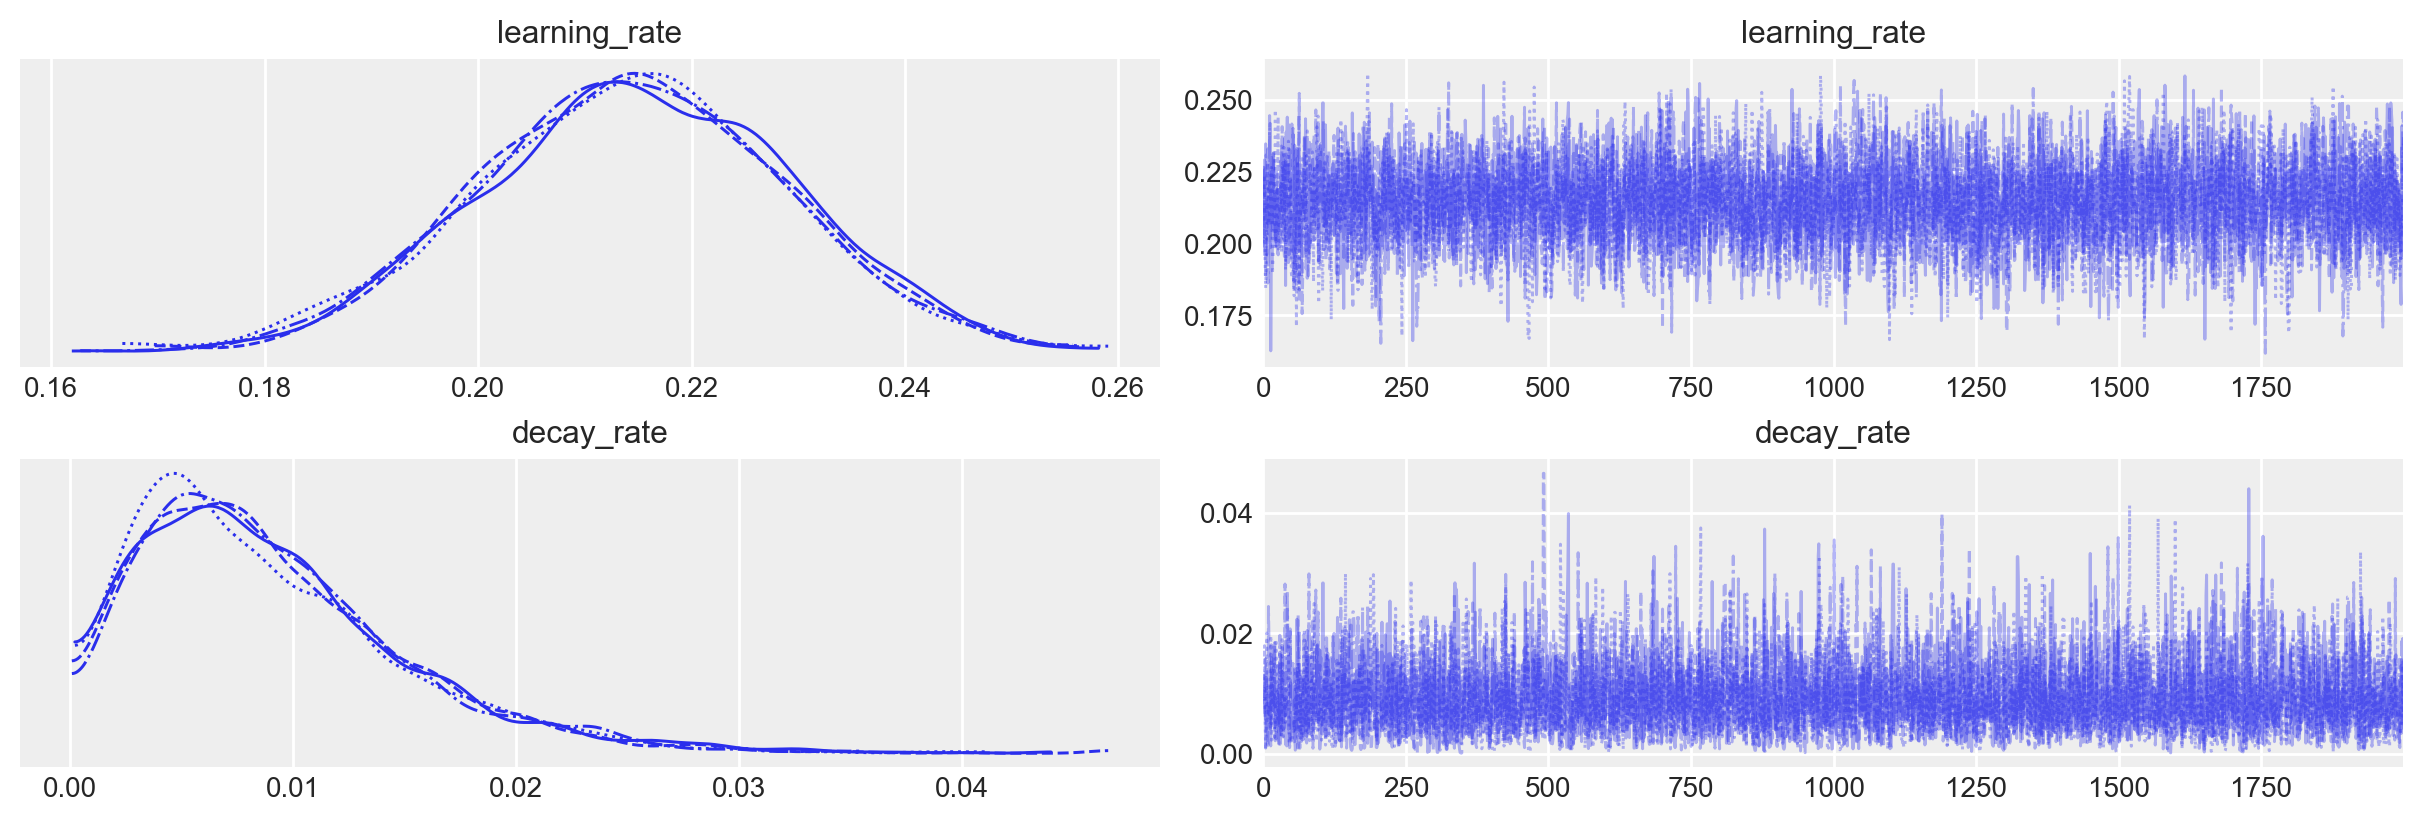

In [14]:
_ = az.plot_trace(fit_process, var_names=("learning_rate", "decay_rate"))

In [17]:
az.summary(fit_process, var_names=["learning_rate", "decay_rate"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
learning_rate,0.214,0.015,0.187,0.241,0.0,0.0,4908.0,5214.0,1.0
decay_rate,0.009,0.006,0.000,0.020,0.0,0.0,4692.0,3553.0,1.0


In [18]:
fit_simpler = simpler_model.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

07:57:33 - cmdstanpy - INFO - CmdStan start processing
07:57:33 - cmdstanpy - INFO - Chain [1] start processing
07:57:33 - cmdstanpy - INFO - Chain [2] start processing
07:57:33 - cmdstanpy - INFO - Chain [3] start processing
07:57:33 - cmdstanpy - INFO - Chain [4] start processing
07:57:44 - cmdstanpy - INFO - Chain [2] done processing
07:57:44 - cmdstanpy - INFO - Chain [4] done processing
07:57:44 - cmdstanpy - INFO - Chain [1] done processing
07:57:45 - cmdstanpy - INFO - Chain [3] done processing


## Confronto dei Modelli

Per confrontare i modelli, è necessario convertire l'oggetto `fit` in un formato compatibile con ArviZ.

In [19]:
idata_process = az.from_cmdstanpy(posterior=fit_process)
idata_simpler = az.from_cmdstanpy(posterior=fit_simpler)

Calcoliamo il criterio LOO (Leave-One-Out) per confrontare i due modelli.

In [20]:
loo_process = az.loo(idata_process)
loo_simpler = az.loo(idata_simpler)

Confrontiamo i due modelli utilizzando il criterio LOO.

In [21]:
loo_comparison = az.compare(
    {"Process Model": loo_process, "Simpler Model": loo_simpler}
)
print(loo_comparison)

               rank     elpd_loo     p_loo  elpd_diff    weight         se  \
Process Model     0 -3123.273484  2.008705   0.000000  0.685872  24.569185   
Simpler Model     1 -3149.844801  1.991303  26.571317  0.314128  24.127268   

                     dse  warning scale  
Process Model   0.000000    False   log  
Simpler Model  12.069884    False   log  


L'output di `loo_comparison()` confronta i due modelli utilizzando il criterio di Leave-One-Out Cross-Validation (LOO) basato sull'Expected Log Predictive Density (ELPD). Ogni colonna nell'output fornisce informazioni diverse sul confronto tra i modelli. Vediamo cosa significa ciascuna colonna:

1. **rank**: Questa colonna indica la posizione del modello in base all'ELPD. Il modello con il valore più alto di ELPD è classificato al primo posto.

2. **elpd_loo**: Questo valore rappresenta la *Expected Log Pointwise Predictive Density* calcolata usando il metodo LOO. In parole semplici, misura quanto bene il modello predice i dati osservati, tenendo conto della complessità del modello per evitare l'overfitting. Un valore più alto indica che il modello ha una migliore capacità predittiva.

3. **p_loo**: Questa colonna stima il numero effettivo di parametri del modello, cioè quanti "gradi di libertà" effettivi il modello sta usando per adattarsi ai dati. Un valore più alto indica un modello più complesso.

4. **elpd_diff**: Questa colonna mostra la differenza di ELPD tra il modello migliore (quello al primo posto) e gli altri modelli. Per il modello migliore, questo valore è 0. Gli altri modelli avranno valori positivi, che indicano quanto peggio si comportano rispetto al modello migliore.

5. **weight**: Questo valore rappresenta la probabilità normalizzata che ciascun modello sia il migliore per fare previsioni su nuovi dati. I pesi sono normalizzati in modo che la somma sia pari a 1. Per esempio, un peso di 0.685872 indica che c'è il 68.6% di probabilità che quel modello sia il migliore nel predire nuovi dati.

6. **se**: Questo è l'errore standard dell'ELPD stimato, che rappresenta l'incertezza associata a questa stima. Un errore standard più basso indica maggiore fiducia nell'ELPD calcolato.

7. **dse**: Significa "errore standard della differenza dell'ELPD". Indica l'incertezza nella differenza di ELPD tra il miglior modello e un altro modello. Un valore basso di `dse` suggerisce che siamo abbastanza sicuri che la differenza osservata non sia dovuta al caso.

8. **warning**: Questa colonna indica se ci sono stati avvertimenti durante il calcolo. Se il valore è `False`, significa che non ci sono stati problemi.

9. **scale**: Indica la scala utilizzata per il confronto tra modelli. In questo caso, si usa la scala logaritmica (`log`), che è comune quando si analizzano log-verosimiglianze.

**Interpretazione**

- **Classifica dei Modelli**: Il `Process Model` è classificato al primo posto, il che significa che ha l'ELPD più alto e, quindi, si adatta meglio ai dati rispetto al `Simpler Model`.

- **Differenza in ELPD (`elpd_diff`)**: La differenza tra i due modelli è significativa (135,85), il che suggerisce che il `Process Model` offre una capacità predittiva notevolmente migliore.

- **Pesi**: Il `Process Model` ha un peso di 0.686, il che indica che, secondo il confronto LOO, c'è una probabilità del 68.6% che sia il miglior modello per fare previsioni su nuovi dati, mentre il `Simpler Model` ha solo il 31.4% di probabilità.

- **Errore Standard della Differenza (`dse`)**: La `dse` relativamente bassa rispetto all'`elpd_diff` conferma che la differenza tra i modelli è significativa e non è dovuta a variazioni casuali.

In conclusione, questo output suggerisce chiaramente che il `Process Model`, che incorpora un processo cognitivo più complesso, è nettamente superiore al `Simpler Model` per quanto riguarda l'adattamento ai dati. Questa superiorità è supportata sia dal confronto delle stime di ELPD sia dai pesi associati ai modelli.

## Riflessioni Conclusive

I risultati ottenuti dimostrano chiaramente l'importanza di implementare un modello che rifletta il processo generativo dei dati (@McElreath_rethinking). Il modello “process,” che cattura la complessità delle dinamiche di apprendimento e decadimento, ha mostrato una performance superiore rispetto al modello più semplice, che si limita a distinguere tra due condizioni. Questo sottolinea come un'analisi basata su un modello che incorpora le ipotesi sul processo sottostante possa portare a una migliore comprensione dei dati e, in ultima analisi, a risultati più solidi.

È fondamentale eseguire simulazioni preliminari prima di raccogliere dati empirici. Queste simulazioni permettono di valutare l'adeguatezza della numerosità campionaria necessaria a rilevare gli effetti ipotizzati, tenendo conto del processo generativo dei dati. Nel caso presente, l'analisi è stata semplificata concentrandosi su un singolo campione di osservazioni indipendenti. Tuttavia, in un contesto più realistico, sarebbe opportuno considerare dati provenienti da più soggetti e riformulare il modello in modo gerarchico per catturare la variabilità tra individui. Lo scopo qui era limitato al confronto tra i due modelli per evidenziare l'importanza di modellare il processo generativo.

L'approccio bayesiano, e in particolare l'uso di Stan, offre un vantaggio notevole in questo contesto, consentendo di implementare in modo relativamente semplice modelli complessi che riflettono fedelmente il processo generativo ipotizzato. Questo tipo di modellazione risulta molto più difficile, se non impossibile, utilizzando metodi non bayesiani, che spesso non permettono di catturare con la stessa flessibilità le dinamiche sottostanti ai dati.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Wed Aug 21 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.13.2
matplotlib: 3.9.1
arviz     : 0.18.0
numpy     : 1.26.4

Watermark: 2.4.3

